# Forward-Forward Algorithm: Some Preliminar Investigation

The FF algorithm has been proposed by G.Hinton few months ago and it's a new learning produce to update the weigths of a neural network that would be a possible alternative to the back-propagation.

The basic idea of the FF algorithm is to replace the forward and backward passes of the classic back-propagation, with two forward passes: one with positive data and one with negative data. In the first case we aim to increase the goodness, and in the second case we want to minimize the goodness of the negative data. So, after the training the network is able to recognize positive and negative data. Usally, the positive data are the real data, while the negative data are hand-crafted, on the purpose to help the learning.



## Step 0. Prepare the dataset 

Like it's done in the Hinton's paper I've tried to evaluate the FF algorithm on the MNIST dataset. From the original dataset, made of 70000 digit images (60000 for the train set and 10000 for the test set), I've made a train/validation split, to monitor the performance of generalization of the model during the training phase.

Moreover, with the purpose of using the FF algorithm we have to create the positive and the negative data. In this case, I've implemented a supervised approach of the FF algorithm and so, for each sample, a one-hot encoding of the correct target is encapsulated in the first 10 features of the image. For the positive data is considered the respective target, instead for the negative data a random label is inserted in the image (always different from the correct one).

In [1]:
import math
import sympy as sp
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from torchvision.datasets import MNIST
import torchvision
import torchvision.transforms as transforms
import copy
from sklearn.model_selection import train_test_split

# Tranform and standardize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # means and variance are taken from Internet
    transforms.Lambda(lambda x: torch.flatten(x))
])

# Load the MNIST training and test data
ds_train = MNIST(root='./data', download=True, train=True, transform=transform)
ds_test  = MNIST(root='./data', download=True, train=False, transform=transform)

 # Make a train/val split
val_size = 10000
(ds_training, ds_val) = torch.utils.data.random_split(ds_train, (len(ds_train)-val_size, val_size))


In [4]:
batch_size = 500

from torch.utils.data import DataLoader
dl_train = DataLoader(ds_training, batch_size, shuffle=True)
dl_val = DataLoader(ds_val,batch_size, shuffle=True)
dl_test = DataLoader(ds_test, len(ds_test), shuffle=False)


In [5]:
def OverlapLabel(x, y):

    # Replace the first 10 pixels of data with a one-hot-encoded label
    modified_x = x.clone()
    modified_x[:, :10] = 0.0
    modified_x[range(x.shape[0]), y] = x.max() 
    return modified_x

In [7]:
def PrepareData(dl): 
  NegData = []
  PosData = []
  
  for (x,y) in tqdm(dl, total=len(dl)):

    # The positive data are made overlapping the right label
    xpos = OverlapLabel(x,y) 
    PosData.append((xpos,y))

    neg_labels=[]
    for index in range(len(x)):

      label = torch.randint(low=0,high=10,size=(1,))
      while label == y[index]:
        # The label is replaced all the times the drawn label is the true label
        label = torch.randint(low=0,high=10,size=(1,))
      neg_labels.append(label) 
      
    # The negative data are made overlapping a wrong label
    xneg = OverlapLabel(x,neg_labels)
    NegData.append((xneg,neg_labels))

  return PosData,NegData

  0%|          | 0/100 [00:00<?, ?it/s]

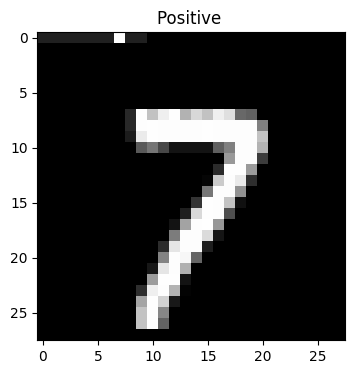


LABEL: 7 



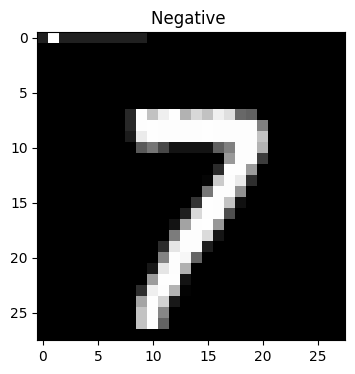


LABEL: 1 



In [24]:
PositiveTrainset,NegativeTrainset = PrepareData(dl_train)

pos_data = next(iter(PositiveTrainset))
neg_data = next(iter(NegativeTrainset))

def visulize_digit(data,title):
  reshaped = data.cpu().reshape(28, 28)
  plt.figure(figsize = (4, 4))
  plt.title(title)
  plt.imshow(reshaped, cmap="gray")
  plt.show()

_ = visulize_digit(pos_data[0][0],"Positive ")
print("\nLABEL:",pos_data[1][0].item(),"\n" )
_ = visulize_digit(neg_data[0][0],"Negative ")
print("\nLABEL:",neg_data[1][0].item(),"\n" )

## Step 1.  Let's implement the Forward-Forward Algorithm

To implent the FF algorithm each layes must have its own objective function to optimize, that aims to return high goodness for positive data and low goodness for negative data. So, we have extend the nn.Linear class incuding a method to compute the goodness and train the layer.

In [9]:
class LinearFFLayer(nn.Linear):
    def __init__(self,input_features,output_features,a='ReLU',lr = 0.1,threshold=10,bias=True,device ='cuda'):
        super().__init__(input_features, output_features, bias, device)
        self.lr=lr
        self.opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.threshold = threshold
        self.activation = self.act(a)
        self.device = device
        
 
    # We can choose any of this activations, but ReLU() is the standard choice
    def act(self, a):
      if a == 'Tanh':
        return nn.Tanh()
      if a == 'Sigmoid':
        return nn.Sigmoid()
      if a == 'ReLU':
        return nn.ReLU()

    def forward(self,x):
      x = x.to(self.device)

      # The forward pass through the layer needs to normalize the input
      x = x/torch.linalg.norm(x+1e-9,ord=2,dim=1, keepdim=True) 

      return self.activation(torch.mm(x,self.weight.T)+self.bias.unsqueeze(0))
  
    def train_batch(self,xpos,xneg,l=2):
          
          # There two possible types of loss that can be used
          if l==1:
            PosGoodness = self.forward(xpos).pow(2).mean(dim=1)
            NegGoodness = self.forward(xneg).pow(2).mean(dim=1)
            loss = torch.log(1+torch.exp(torch.cat([-PosGoodness + self.threshold,NegGoodness - self.threshold]))).mean()
            
          if l==2:
            metric = torch.cat((torch.sigmoid(torch.mean(self.forward(xpos).pow(2),dim=1)-self.threshold),torch.sigmoid(torch.mean(self.forward(xneg).pow(2),dim=1)-self.threshold)))
            loss = torch.nn.functional.binary_cross_entropy(metric,torch.cat(((torch.zeros(len(xpos))).cuda()+1,torch.zeros(len(xneg)).cuda())), reduction = "mean")
          
          self.opt.zero_grad()
          loss.backward()
          self.opt.step()

          return loss.item()
          

In [26]:
class FFNetwork(nn.Module):
    def __init__(self,layers,a='ReLU',device='cuda',threshold = 10,lr=0.1):
        super().__init__()

        self.layers = []
        for i in range(len(layers)-1):
          self.layers.append(LinearFFLayer(layers[i],layers[i+1],a=a,device=device, threshold=threshold, lr=lr))
          torch.nn.init.xavier_uniform_(self.layers[i].weight)
        self.lr=lr
        self.threshold = threshold
        self.device = device
     
    def forward(self,x):
      for layer in self.layers:
        x = layer(x)
      return x

    def FFtrain(self,epochs,train_data,val_data = None,l=1):
     
      # First of all we need to create the positive and negative train data
      print("Preparing the train set:")
      train_PosData,train_NegData = PrepareData(train_data)
      train_accuracy = []
      train_loss = []
      

      if val_data:
        # In the case of validation, we need positive and negative validation sets
        print("Preparing the validation set:")
        val_PosData,val_NegData = PrepareData(val_data)
        val_accuracy = []
        val_loss = []

      
      # This is a progressive training, i.e., it's learned one layer at a time
      for i,layer in enumerate(self.layers):

        # It's used a simple the step learning rate schedule
        scheduler = torch.optim.lr_scheduler.StepLR(layer.opt, step_size=1, gamma=0.9)#step_size=50 for the cross-validation routine
        for k in tqdm(range(epochs),desc=f'Training layer {i}'):

          train_batch_loss = []
          batch_accuracy = []
          for (xpos,ypos),(xneg,yneg) in zip(train_PosData,train_NegData):
                copy_xpos,copy_ypos = xpos,ypos # Used after to make prediction
                with torch.no_grad():    
                    j=0
                    while j<i:
                      xpos=self.layers[j].forward(xpos).detach()
                      xneg=self.layers[j].forward(xneg).detach()
                      j=j+1

                self.train()#model.train()

                # Train the model with a batch of samples and return the loss
                train_batch_loss.append(layer.train_batch(xpos,xneg,l))

                self.eval()# model.eval()
            
                if k%5==0 or k==epochs-1:
                  with torch.no_grad():

                    # Compute the train accuracy
                    batch_accuracy.append(self.predict(copy_xpos,l).cpu().eq(copy_ypos).float().mean().item())# We use the positive data since then the prediction method overlap every label
              

          if k%5==0 or k==epochs-1:
              train_loss.append(np.mean(train_batch_loss))
              train_accuracy.append(np.mean(batch_accuracy))


          #scheduler.step()# -> used for the cross-validation routine

          if val_data and (k%5==0 or k==epochs-1) :
              val_l=[]
              val_acc = []
              with torch.no_grad():

                for (val_xpos,val_ypos),(val_xneg,val_yneg) in zip(val_PosData,val_NegData):
                  # Compute the validation accuracy
                  val_acc.append(self.predict(val_xpos,l).cpu().eq(val_ypos).float().mean().item())

                  j=0
                  while j<i:
                    val_xpos=self.layers[j].forward(val_xpos).detach()
                    val_xneg=self.layers[j].forward(val_xneg).detach()
                    j+=1

                  # Compute the loss on the validation set
                  if l==1:
                      PosGoodness = layer.forward(val_xpos).pow(2).mean(dim=1)
                      NegGoodness = layer.forward(val_xneg).pow(2).mean(dim=1)
                      loss = torch.log(1+torch.exp(torch.cat([-PosGoodness + self.threshold,NegGoodness - self.threshold]))).mean()
                      
                  if l==2:
                      metric = torch.cat((torch.sigmoid(torch.mean(layer.forward(val_xpos).pow(2),dim=1)-self.threshold),torch.sigmoid(torch.mean(layer.forward(val_xneg).pow(2),dim=1)-self.threshold)))
                      loss = torch.nn.functional.binary_cross_entropy(metric,torch.cat(((torch.zeros(len(val_xpos))).cuda()+1,torch.zeros(len(val_xneg)).cuda())), reduction = "mean")
                  
                  val_l.append(loss.item())
              
              val_accuracy.append(np.mean(val_acc))
              val_loss.append(np.mean(val_l))

              # If the validion loss increses the lr is reduced 
              if np.mean(val_l) > np.min(val_loss) and k > 10:
                scheduler.step()
  
      if val_data:
        return train_accuracy,train_loss,val_accuracy,val_loss
      else:
        return train_accuracy,train_loss,None,None


    def predict(self, x,l=2):
       x = x.to(device)
       goodness_per_label = []
       with torch.no_grad():
        for label in range(10):

            #For each label we consider the data with this label and we compute the goodness
            h = OverlapLabel(x, label)
            goodness = []
            for i,layer in enumerate(self.layers):
              
                h = layer.forward(h)
                goodness.append(torch.mean(h.pow(2),dim=1))

            #  For each type of loss we have to consider a slightly different type of accumulated goodness
            if l==1:
                  goodness_per_label.append(sum(goodness).unsqueeze(dim=1))
            if l==2:
                  goodness_per_label.append(torch.sigmoid(sum(goodness)-self.threshold*len(self.layers)).unsqueeze(dim=1))
            
        goodness_per_label = torch.cat(goodness_per_label, dim=1)

        return goodness_per_label.argmax(dim=1)


In [21]:
from sklearn.model_selection import KFold

def ThersholdCrossValidation(classifier,ds_train,thresholds,cv=5,epochs=100,lr=0.1):

    thresholds_train_accuracy = []
    thresholds_val_accuracy = []

    for threshold in thresholds: 
        print("CROSS_VALIDATION THRESHOLD =",threshold)
      
        train_accuracy = []
        val_accuracy = []

        # Divide the dataset into K folds
        kf=KFold(n_splits=cv)

        for fold, (train_index, val_index) in enumerate(kf.split(np.arange(len(ds_train)))):
        
            train_fold = torch.utils.data.SubsetRandomSampler(train_index)
            val_fold = torch.utils.data.SubsetRandomSampler(val_index)

            train_loader = torch.utils.data.DataLoader(ds_train, batch_size=500, sampler=train_fold)
            val_loader =torch.utils.data.DataLoader(ds_train, batch_size=500, sampler=val_fold)

            print("FOLD n.",fold,"\n")
            
            # Create a new istance of the passed model
            cv_model = FFNetwork([], device = device, threshold = threshold, lr = lr)
            cv_model.layers=copy.deepcopy(classifier.layers)
            for i in range(len(cv_model.layers)):
              cv_model.layers[i].threshold = threshold

            batch_val_accuracy = []
            batch_test_accuracy = []

            # Train the model with K-1 folds
            batch_train_accuracy,batch_train_loss,_,_ = cv_model.FFtrain(epochs=epochs,train_data=train_loader,l=2)#or l=1
            
            with torch.no_grad():

            # Test the performance with one fold
              for x,y in val_loader:
                  batch_val_accuracy.append(cv_model.predict(x).cpu().eq(y).float().mean().item())


            print("Fold",fold,"Train accuracy: ",batch_train_accuracy[-1])
            print("Fold",fold,"Train loss: ",batch_train_loss[-1])
            print("Fold",fold,"Val accuracy: ",np.mean(batch_val_accuracy))

            train_accuracy.append(batch_train_accuracy[-1])
            val_accuracy.append(np.mean(batch_val_accuracy))
            print("\n")
    
        thresholds_train_accuracy.append(np.mean(train_accuracy))
        thresholds_val_accuracy.append(np.mean(val_accuracy))

    return thresholds_train_accuracy,thresholds_val_accuracy


In [23]:
thresholds = [19]
cv_model = FFNetwork([28*28,512,512], device=device, lr=0.1)

print(ThersholdCrossValidation(cv_model,ds_train,thresholds,cv=5,epochs=150,lr=0.1))

CROSS_VALIDATION THRESHOLD = 19
FOLD n. 0 

Preparing the train set:


  0%|          | 0/96 [00:00<?, ?it/s]

Training layer 0:   0%|          | 0/150 [00:00<?, ?it/s]

Training layer 1:   0%|          | 0/150 [00:00<?, ?it/s]

Fold 0 Train accuracy:  0.9919374994933605
Fold 0 Train loss:  7.212496552710945e-05
Fold 0 Val accuracy:  0.9752500082055727


FOLD n. 1 

Preparing the train set:


  0%|          | 0/96 [00:00<?, ?it/s]

Training layer 0:   0%|          | 0/150 [00:00<?, ?it/s]

Training layer 1:   0%|          | 0/150 [00:00<?, ?it/s]

Fold 1 Train accuracy:  0.9921250014255444
Fold 1 Train loss:  7.513974170099876e-05
Fold 1 Val accuracy:  0.9723333393534025


FOLD n. 2 

Preparing the train set:


  0%|          | 0/96 [00:00<?, ?it/s]

Training layer 0:   0%|          | 0/150 [00:00<?, ?it/s]

Training layer 1:   0%|          | 0/150 [00:00<?, ?it/s]

Fold 2 Train accuracy:  0.992333335801959
Fold 2 Train loss:  7.040022952272314e-05
Fold 2 Val accuracy:  0.9722500046094259


FOLD n. 3 

Preparing the train set:


  0%|          | 0/96 [00:00<?, ?it/s]

Training layer 0:   0%|          | 0/150 [00:00<?, ?it/s]

Training layer 1:   0%|          | 0/150 [00:00<?, ?it/s]

Fold 3 Train accuracy:  0.9921666694184145
Fold 3 Train loss:  7.301425879783589e-05
Fold 3 Val accuracy:  0.96891667197148


FOLD n. 4 

Preparing the train set:


  0%|          | 0/96 [00:00<?, ?it/s]

Training layer 0:   0%|          | 0/150 [00:00<?, ?it/s]

Training layer 1:   0%|          | 0/150 [00:00<?, ?it/s]

Fold 4 Train accuracy:  0.9909791642179092
Fold 4 Train loss:  7.558943366348103e-05
Fold 4 Val accuracy:  0.9754166727264723


([0.9919083340714374], [0.9728333393732707])


In [14]:
model = FFNetwork([28*28,2048,2048], device=device,threshold=19, lr=0.1) 
ep=150
train_acc,train_loss,val_acc, val_loss = model.FFtrain(ep,dl_train,dl_test,dl_val,l=2)

Preparing the train set:


  0%|          | 0/100 [00:00<?, ?it/s]

Preparing the validation set:


  0%|          | 0/20 [00:00<?, ?it/s]

Training layer 0:   0%|          | 0/150 [00:00<?, ?it/s]

Training layer 1:   0%|          | 0/150 [00:00<?, ?it/s]

Max train accuracy: 0.9909600013494492 at epoch 295
Min train loss: 0.00014465094180195591 at epoch 299
Max val accuracy: 0.9750999987125397 at epoch 295
Min val loss: 0.04844895042479038 at epoch 190 

Final train loss: 0.00014465094180195591
Final val loss: 0.0574411713052541
Final train accuracy: 0.9909600007534027
Final val accuracy: 0.9749999970197678 



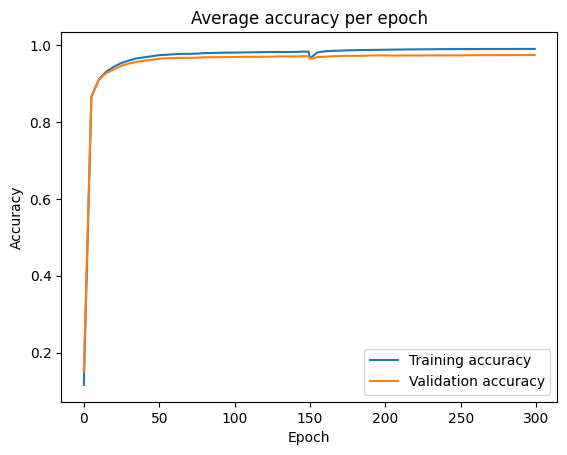

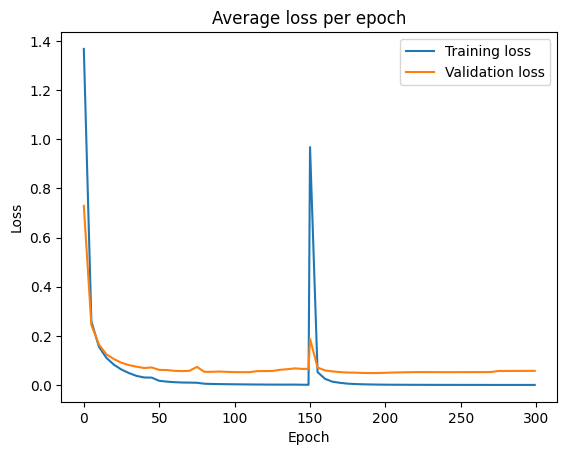

In [16]:
plt.figure()
ax=np.concatenate((np.arange(0,ep,5),[ep-1],np.arange(ep,2*ep,5),[2*ep-1]))#,np.arange(2*ep,3*ep,5),[3*ep-1],np.arange(3*ep,4*ep,5),[4*ep-1])) for more layers
plt.plot(ax,train_acc, label = "Training accuracy")
plt.plot(ax,val_acc, label = "Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.title('Average accuracy per epoch')

plt.figure()
plt.plot(ax,train_loss,label = "Training loss")
plt.plot(ax,val_loss,label = "Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.title('Average loss per epoch')

print("Max train accuracy:",max(train_acc), "at epoch", ax[np.argmax(train_acc)])
print("Min train loss:",min(train_loss), "at epoch", ax[np.argmin(train_loss)]) 
print("Max val accuracy:",max(val_acc), "at epoch", ax[np.argmax(val_acc)])
print("Min val loss:",min(val_loss), "at epoch", ax[np.argmin(val_loss)],"\n")

print("Final train loss:",train_loss[-1])
print("Final val loss:",val_loss[-1])
print("Final train accuracy:",train_acc[-1])
print("Final val accuracy:",val_acc[-1],"\n")


In [15]:
Xtest,ytest = next(iter(dl_test))
print(classification_report(ytest, model.predict(Xtest).cpu(), zero_division=0, digits=3))
print("Test accuracy: ",model.predict(Xtest).cpu().eq(ytest).float().mean().item())
print('Test error:', 1.0 - model.predict(Xtest).cpu().eq(ytest).float().mean().item(),"\n")

              precision    recall  f1-score   support

           0      0.981     0.991     0.986       980
           1      0.989     0.991     0.990      1135
           2      0.979     0.971     0.975      1032
           3      0.972     0.981     0.976      1010
           4      0.977     0.968     0.973       982
           5      0.989     0.971     0.980       892
           6      0.985     0.985     0.985       958
           7      0.976     0.967     0.972      1028
           8      0.961     0.975     0.968       974
           9      0.961     0.965     0.963      1009

    accuracy                          0.977     10000
   macro avg      0.977     0.977     0.977     10000
weighted avg      0.977     0.977     0.977     10000

Test accuracy:  0.9768000245094299
Test error: 0.02319997549057007 



## 2.  Let's compare the performance with other models


**Support Vector Machine**

In [ ]:
from sklearn.svm import LinearSVC

# Preprocess the data
svm_train_data = ds_train.data.to(torch.float32)
svm_train_targets = ds_train.targets
svm_test_data = ds_test.data.to(torch.float32)
svm_test_targets = ds_test.targets

svm_train_data = svm_train_data.flatten(1,2)
svm_test_data = svm_test_data.flatten(1,2)

# Train the model consider the dual form of the optimization problem
SVM=LinearSVC(max_iter=1000, dual=False)
SVM.fit(svm_train_data,svm_train_targets)

print(classification_report(svm_test_targets, SVM.predict(svm_test_data), zero_division=0, digits=3))

              precision    recall  f1-score   support

           0      0.951     0.981     0.965       980
           1      0.959     0.978     0.969      1135
           2      0.925     0.879     0.901      1032
           3      0.896     0.908     0.902      1010
           4      0.918     0.933     0.925       982
           5      0.882     0.860     0.871       892
           6      0.929     0.949     0.939       958
           7      0.923     0.917     0.920      1028
           8      0.873     0.866     0.869       974
           9      0.902     0.888     0.895      1009

    accuracy                          0.917     10000
   macro avg      0.916     0.916     0.916     10000
weighted avg      0.917     0.917     0.917     10000



**Multi-Layer Perceptron trained with back-progation**

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28,512)
    self.fc2 = nn.Linear(512,512)
    self.fc3 = nn.Linear(512,10)
    self.output = torch.nn.LogSoftmax(dim=1)
    self.relu = nn.ReLU()

  def forward(self,x):
      x = self.relu(self.fc1(x.view(len(x), -1)))
      x = self.relu(self.fc2(x))
      x = self.output(self.fc3(x)) 
      return x

In [ ]:
def train_epoch(model, dl_train,dl_val, opt, device='cuda'):
    model.train()
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    # Train the model for an epoch, compute the loss and evaluate the training accuracy
    for (xs, ys) in dl_train:  

        model.train()

        xs = xs.to(device)
        ys = ys.to(device)

        opt.zero_grad()
        logits = model(xs)
        loss = torch.nn.functional.nll_loss(logits,ys, reduction = "mean")
        loss.backward()
        opt.step()
        train_loss.append(loss.item())
        
        model.eval()
        preds = torch.argmax(model(xs), dim=1)
        train_acc.append(accuracy_score(ys.cpu(),preds.detach().cpu().numpy()))

    # Evaluate the model and compute the loss for the validation set
    for (xs, ys) in dl_val:

        xs = xs.to(device)
        ys = ys.to(device)

        logits = model(xs)
        loss = torch.nn.functional.nll_loss(logits,ys, reduction = "mean")
        val_loss.append(loss.item())

        preds = torch.argmax(model(xs), dim=1)
        val_acc.append(accuracy_score(ys.cpu(),preds.detach().cpu().numpy()))
    
    return np.mean(train_loss),np.mean(val_loss),np.mean(train_acc),np.mean(val_acc)

In [ ]:
from torch.optim import SGD
from sklearn.metrics import accuracy_score

# Define the model parameters
mlp = MLP().to(device)
lr=0.3
epochs=25
optimizer=SGD(mlp.parameters(),lr=lr)

mlp_train_loss = []
mlp_val_loss = []
mlp_val_accuracy = []
mlp_train_accuracy = []

# Train the network and compute losses and accuracies
for c in tqdm(range(epochs),ncols=500,desc="Progress"):

        train_l,val_l,train_a,val_a = train_epoch(mlp,dl_train,dl_val,optimizer)

        mlp_train_loss.append(train_l)
        mlp_val_loss.append(val_l)
        mlp_train_accuracy.append(train_a)
        mlp_val_accuracy.append(val_a)

        if c%5==0 or c==epochs-1:
          print("Train accuracy at epoch",c,"is",train_a)
          print("Validation accuracy at epoch",c,"is",val_a)
          print("\nTraining loss at epoch",c,"is",train_l)
          print("Validation loss at epoch",c,"is",val_l)
          print("----------------------------------------")

Progress:   0%|                                                                                               …

Train accuracy at epoch 0 is 0.8648600000000001
Validation accuracy at epoch 0 is 0.9383000000000002

Training loss at epoch 0 is 0.5472360390424729
Validation loss at epoch 0 is 0.21229113414883613
----------------------------------------
Train accuracy at epoch 5 is 0.99422
Validation accuracy at epoch 5 is 0.9743000000000002

Training loss at epoch 5 is 0.05753140050917864
Validation loss at epoch 5 is 0.0865263493731618
----------------------------------------
Train accuracy at epoch 10 is 0.99926
Validation accuracy at epoch 10 is 0.9802

Training loss at epoch 10 is 0.02086706287227571
Validation loss at epoch 10 is 0.06873727971687912
----------------------------------------
Train accuracy at epoch 15 is 0.9999199999999999
Validation accuracy at epoch 15 is 0.9812999999999998

Training loss at epoch 15 is 0.007452034275047481
Validation loss at epoch 15 is 0.06609050007537007
----------------------------------------
Train accuracy at epoch 20 is 0.9999800000000001
Validation acc

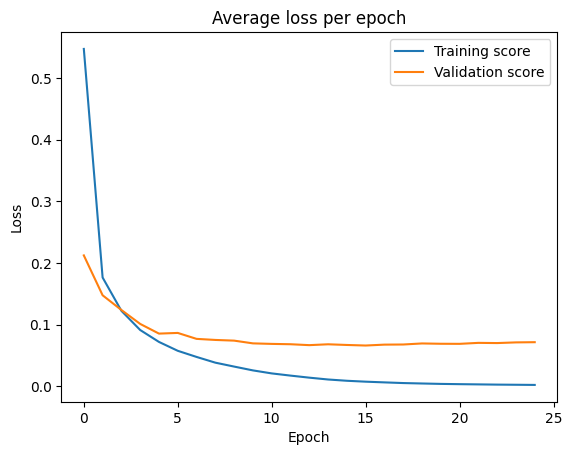

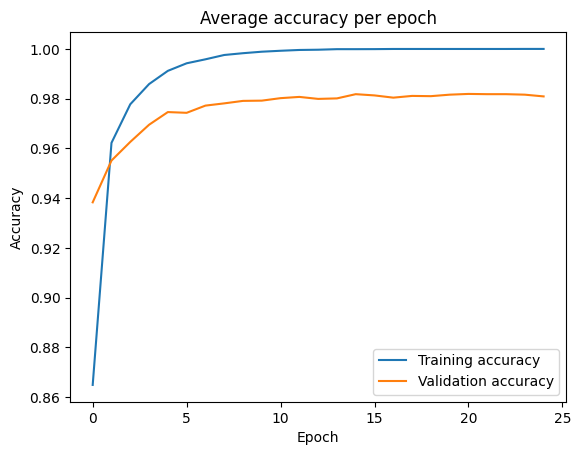

In [ ]:
plt.figure()
plt.title('Average loss per epoch')
plt.plot(mlp_train_loss,label="Training score")
plt.plot(mlp_val_loss,label="Validation score")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.title(f'Average accuracy per epoch')
plt.plot(mlp_train_accuracy,label="Training accuracy")
plt.plot(mlp_val_accuracy,label="Validation accuracy")
plt.legend(loc="best")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
# Test the performance of the model: make predictions and classification report on the test set
def evaluate_model(model, dl, device='cuda'):
    predictions = []
    targets = []

    for xs,ys in dl:
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        targets.append(ys)
        predictions.append(preds.detach().cpu().numpy())

    return (accuracy_score(np.hstack(targets), np.hstack(predictions)), classification_report(np.hstack(targets), np.hstack(predictions), zero_division=0, digits=3))

In [ ]:
mlp_test_acc,report = evaluate_model(mlp,dl_test)
print("Test accuracy :", mlp_test_acc,"\n")
print(report)

Test accuracy : 0.9818 

              precision    recall  f1-score   support

           0      0.980     0.989     0.984       980
           1      0.992     0.992     0.992      1135
           2      0.979     0.981     0.980      1032
           3      0.975     0.983     0.979      1010
           4      0.983     0.982     0.982       982
           5      0.990     0.972     0.981       892
           6      0.984     0.981     0.983       958
           7      0.984     0.980     0.982      1028
           8      0.976     0.977     0.977       974
           9      0.974     0.979     0.977      1009

    accuracy                          0.982     10000
   macro avg      0.982     0.982     0.982     10000
weighted avg      0.982     0.982     0.982     10000



**MLP with FF-based netword as representation extractor**

In [ ]:
class MLP_withFF(nn.Module):
  def __init__(self,feature_extractor):
    super().__init__()

    self.fe =[]
    count=0
    for i,layer in enumerate(feature_extractor.layers):
        count+=layer.out_features
        l=copy.deepcopy(layer)
        self.fe.append(l)

    self.fc = nn.Linear(count,10)
    self.output = torch.nn.LogSoftmax(dim=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    x = x.view(len(x), -1)
    f = []
    for i,layer in enumerate(self.fe):
    
          x = layer(x)
          # The ouput is detached so the gradient cannot be back-propagated
          f.append(x.detach())
          
    x = torch.cat(f,dim=1)
    x = self.output(self.fc(x)) 
    return x

In [ ]:
from torch.optim import SGD
from sklearn.metrics import accuracy_score

# Defining the model parameters
mlp_ff = MLP_withFF(model).to(device)
lr = 0.02 
epochs = 20 
optimizer = SGD(mlp_ff.parameters(),lr=lr)

mlp_ff_train_loss = []
mlp_ff_val_loss = []
mlp_ff_val_accuracy = []
mlp_ff_train_accuracy = []

# Training the network and computing the losses and the accuracies
for c in tqdm(range(epochs),ncols=500,desc="Progress"):
        train_l,val_l,train_a,val_a = train_epoch(mlp_ff,dl_train,dl_val,optimizer)

        mlp_ff_train_loss.append(train_l)
        mlp_ff_val_loss.append(val_l)
        mlp_ff_train_accuracy.append(train_a)
        mlp_ff_val_accuracy.append(val_a)

        if c%5==0 or c==epochs-1:
          print("\nTraining accuracy at epoch",c,"is",train_a)
          print("Validation accuracy at epoch",c,"is",val_a)
          print("\nTraining loss at epoch",c,"is",train_l)
          print("Validation loss at epoch",c,"is",val_l)
          print("----------------------------------------")

Progress:   0%|                                                                                               …


Training accuracy at epoch 0 is 0.9857399999999998
Validation accuracy at epoch 0 is 0.9754

Training loss at epoch 0 is 0.27357143657281996
Validation loss at epoch 0 is 0.16090920567512512
----------------------------------------

Training accuracy at epoch 5 is 0.9996200000000002
Validation accuracy at epoch 5 is 0.9784

Training loss at epoch 5 is 0.010790504262549802
Validation loss at epoch 5 is 0.10892993211746216
----------------------------------------

Training accuracy at epoch 10 is 0.9999799999999999
Validation accuracy at epoch 10 is 0.9778

Training loss at epoch 10 is 0.0034287679719273
Validation loss at epoch 10 is 0.1062106192111969
----------------------------------------

Training accuracy at epoch 15 is 0.9999800000000001
Validation accuracy at epoch 15 is 0.9786

Training loss at epoch 15 is 0.0018086632067570462
Validation loss at epoch 15 is 0.1046520471572876
----------------------------------------

Training accuracy at epoch 19 is 1.0
Validation accuracy at

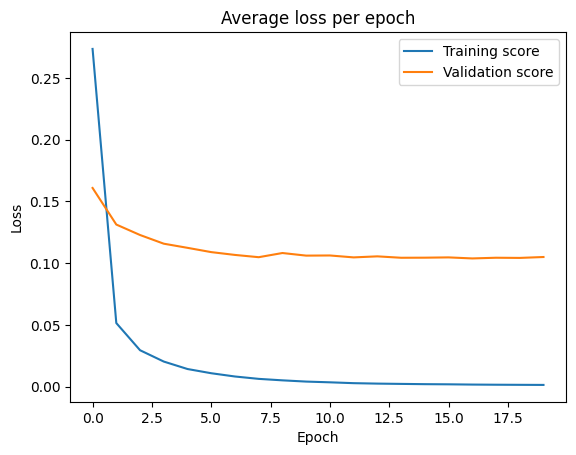

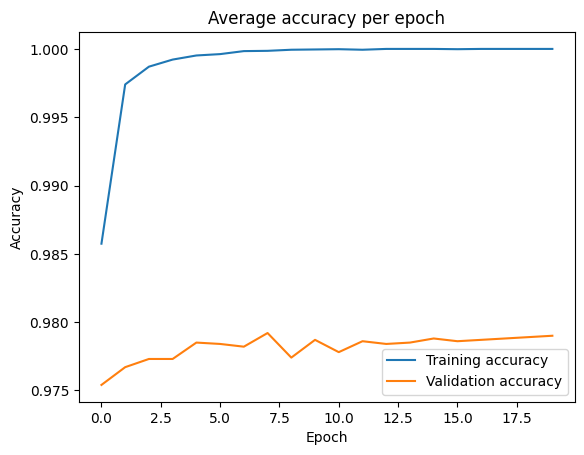

In [ ]:
plt.figure()
plt.title('Average loss per epoch')
plt.plot(mlp_ff_train_loss,label="Training score")
plt.plot(mlp_ff_val_loss,label="Validation score")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.title(f'Average accuracy per epoch')
plt.plot(mlp_ff_train_accuracy,label="Training accuracy")
plt.plot(mlp_ff_val_accuracy,label="Validation accuracy")
plt.legend(loc="best")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
mlp_acc,rep = evaluate_model(mlp_ff,dl_test)
print("Test accuracy :", mlp_acc)
print(rep)

Test accuracy : 0.9818
              precision    recall  f1-score   support

           0      0.983     0.993     0.988       980
           1      0.993     0.989     0.991      1135
           2      0.978     0.983     0.980      1032
           3      0.982     0.984     0.983      1010
           4      0.983     0.979     0.981       982
           5      0.981     0.976     0.979       892
           6      0.984     0.984     0.984       958
           7      0.981     0.977     0.979      1028
           8      0.981     0.976     0.979       974
           9      0.970     0.975     0.973      1009

    accuracy                          0.982     10000
   macro avg      0.982     0.982     0.982     10000
weighted avg      0.982     0.982     0.982     10000

